In [87]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
import importlib

import statmorph
from statmorph.utils.image_diagnostics import make_figure
import utils.data
import utils.plots as plots
%matplotlib inline

In [61]:
drz_file = 'cluster_data/abell2537/hlsp_relics_hst_wfc3ir-60mas_abell2537_f160w_v1_drz.fits'
cat_file = 'cluster_data/abell2537/hlsp_relics_hst_acs-wfc3ir_abell2537_multi_v1_cat.txt'
catalog = pd.read_csv(cat_file, comment='#', sep='\s+', index_col='id')
hdulist = fits.open(drz_file)
drz = hdulist[0].data

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/s0/lggtcgss1ybb5pnxffm57clh0000gn/T/ipykernel_84209/2532552277.py:3: SyntaxWarning: invalid escape sequence '\s'
  catalog = pd.read_csv(cat_file, comment='#', sep='\s+', index_col='id')


In [62]:
catalog.head()

,RA,Dec,x,y,fwhm,area,stel,ell,theta,nf5sig,...,zb,zbmin,zbmax,tb,odds,chisq,chisq2,M0,zml,tml
id,,,,,,,,,,,,,,,,,,,,,
3,347.108769,-2.153719,1881.726,5251.602,0.566,30,0.01,0.686,87.5,2,...,1.400,0.137,3.074,9.1,0.092,0.000,0.00,25.611,1.36,9.2
11,347.108919,-2.154308,1872.729,5216.217,0.086,14,1.00,0.255,-58.9,2,...,1.593,1.474,2.022,11.0,0.724,12.549,26.88,25.267,1.59,11.0
20,347.105390,-2.154959,2084.294,5177.201,0.192,15,0.97,0.368,-10.8,2,...,1.323,0.138,3.188,8.5,0.090,0.000,0.00,25.978,1.83,8.0
23,347.109489,-2.155125,1838.553,5167.189,0.196,37,0.94,0.269,45.4,2,...,1.592,1.551,1.780,11.0,0.931,121.663,539.80,24.206,1.59,11.0
27,347.109209,-2.155329,1855.307,5154.978,0.131,40,0.98,0.193,-15.3,2,...,1.592,1.566,1.710,11.0,0.965,86.624,287.00,24.244,1.59,11.0


In [83]:
galaxies = catalog[catalog['stel'] < 0.05 ]
galaxies.head()

,RA,Dec,x,y,fwhm,area,stel,ell,theta,nf5sig,...,zb,zbmin,zbmax,tb,odds,chisq,chisq2,M0,zml,tml
id,,,,,,,,,,,,,,,,,,,,,
3,347.108769,-2.153719,1881.726,5251.602,0.566,30,0.01,0.686,87.5,2,...,1.400,0.137,3.074,9.1,0.092,0.0,0.000,25.611,1.36,9.2
28,347.105877,-2.155410,2055.078,5150.122,0.534,71,0.00,0.390,-27.7,2,...,0.544,0.207,3.338,7.4,0.135,0.0,0.007,24.489,1.66,6.1
37,347.105753,-2.155865,2062.535,5122.804,0.459,136,0.02,0.263,32.5,2,...,0.545,0.206,1.448,6.4,0.158,0.0,0.000,23.428,9.81,5.5
49,347.108714,-2.156536,1884.982,5082.546,0.572,23,0.00,0.375,-45.9,2,...,1.305,0.133,3.151,8.7,0.090,0.0,0.001,25.583,9.97,5.4
52,347.105924,-2.157199,2052.289,5042.801,0.281,3165,0.03,0.152,75.6,2,...,0.364,0.274,0.814,5.1,0.596,0.0,0.000,19.329,3.83,1.8


In [106]:
z_cluster = 0.2966
cluster_gals = galaxies[np.abs(galaxies['zb'] - z_cluster) < 0.15]
w = drz.shape[1]
h = drz.shape[0]
center = (int(w/2), int(h/2))
bcg = cluster_gals.loc[cluster_gals['area'].idxmax()]

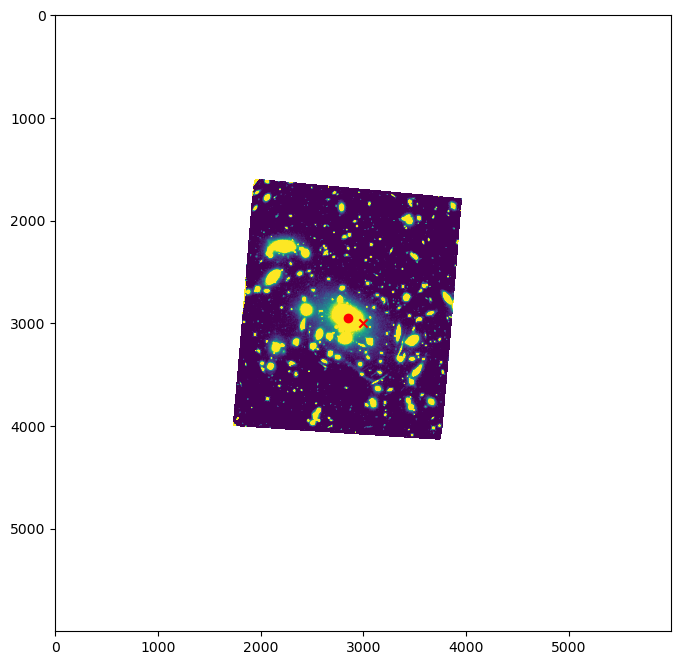

In [107]:
x = cluster_gals['x']
y = cluster_gals['y']
fig, axs = plt.subplots(figsize=(8,8))
plots.display_img(image=drz, axs=axs)
axs.scatter(center[0], center[1], marker='x', color='r')
axs.scatter(bcg['x'], bcg['y'], marker='o', color='r')
plt.show()

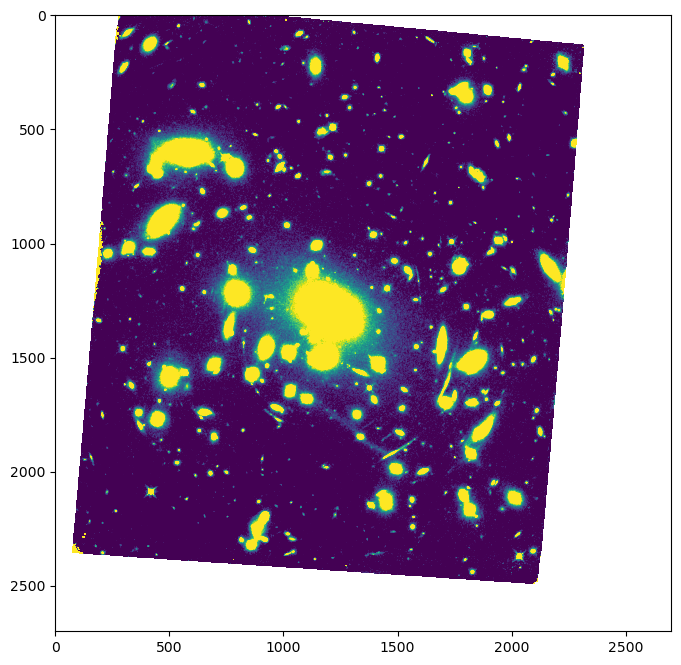

In [93]:
cropped_image = utils.data.crop(drz, radius=1350)
fig, axs = plt.subplots(figsize=(8, 8))
plots.display_img(image=cropped_image, axs=axs)
plt.show()

In [8]:
# full_segmap = segmentation_map(drz, nsigma=10.)
full_segmap = fits.open('cluster_data/abell1300/hlsp_relics_hst_acs-wfc3ir_abell1300_multi_v1_segm.fits')
full_segmap = full_segmap[0].data

In [9]:
full_source_morphs = statmorph.source_morphology(image=drz,
                                                 segmap=full_segmap,
                                                 gain=2.25)

/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/astropy/modeling/functional_models.py:3347: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1.0))
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/astropy/modeling/functional_models.py:3347: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1.0))
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/astropy/modeling/functional_models.py:3347: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1.0))
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/astropy/modeling/functional_models.py:3347: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1.0))
/Users/kabelo/.conda/envs/cluster_morph/lib/python3.13/site-packages/astropy/modeling/functional_models.py:3347: RuntimeWarning: overflow en

In [10]:
def func(src):
    return src.r50      # sort on half-light radius to get BCG

full_source_morphs.sort(reverse=True, key=func)
bcg = full_source_morphs[1]
full_morph_df = create_morph_df(full_source_morphs)

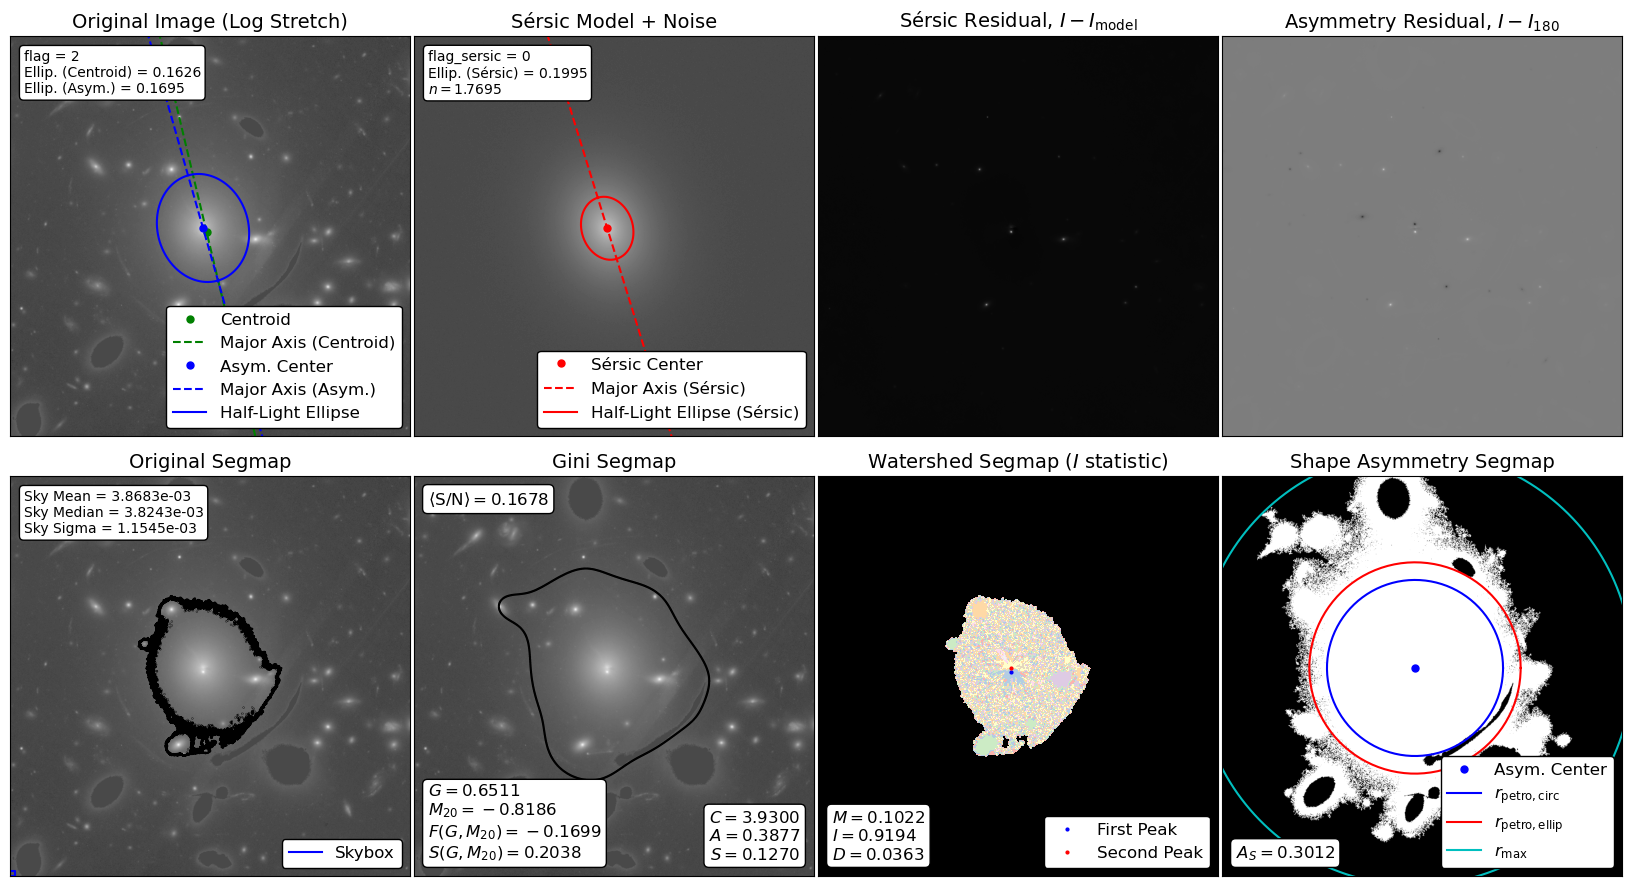

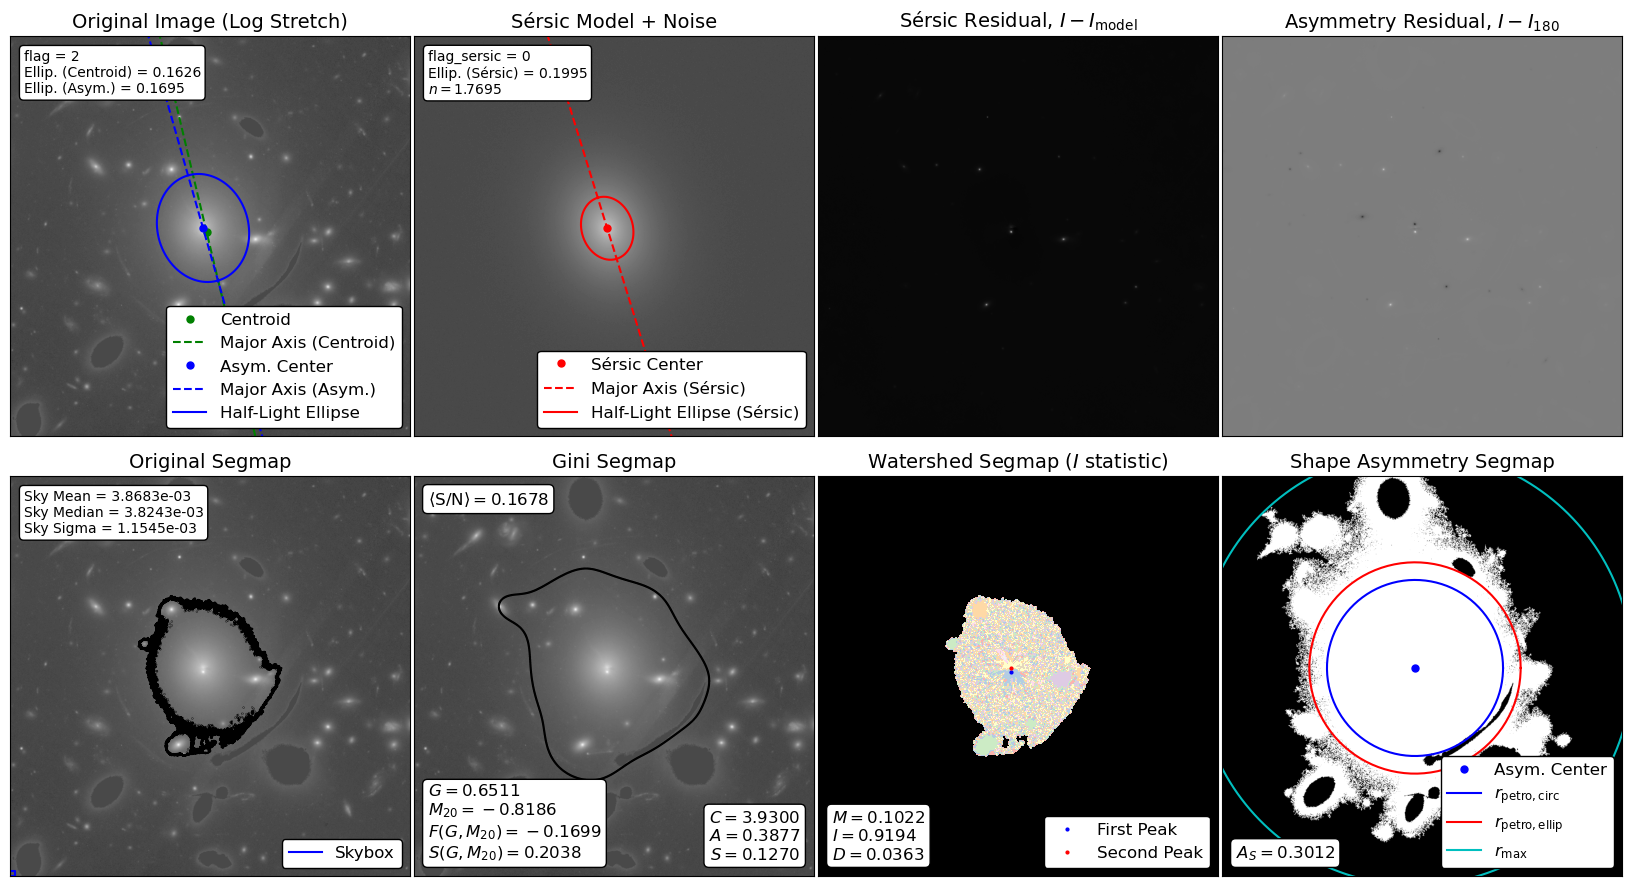

In [7]:
make_figure(bcg)

In [108]:
zoomed_region, zoom_size = zoom_in(bcg, drz)
plot_light(bcg, zoomed_region, zoom_size)

AttributeError: 'Series' object has no attribute 'rhalf_circ'

In [119]:
def zoom_in(object, radius, image):
    """
    Square image crop using statmorph source object properties.
    """
    zoom_size = 6 * radius
    x_min = int(object['x'] - zoom_size)
    x_max = int(object['x'] + zoom_size)
    y_min = int(object['y'] - zoom_size)
    y_max = int(object['y'] + zoom_size)

    # Extract the zoomed region
    zoomed_region = image[y_min:y_max, x_min:x_max]
    return zoomed_region, zoom_size

In [120]:
radius = np.sqrt(bcg['area']/np.pi)
zoomed_region, zoom_size = zoom_in(bcg, radius, drz)

/var/folders/s0/lggtcgss1ybb5pnxffm57clh0000gn/T/ipykernel_84209/3969048197.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


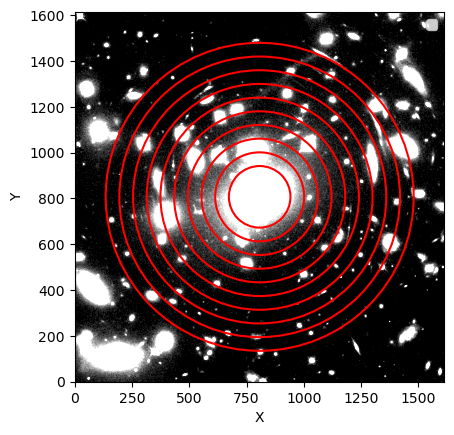

In [121]:
fig, ax = plt.subplots()
ax.imshow(zoomed_region, cmap='gray', origin='lower', vmin=0, vmax=0.05)
for scale in np.linspace(1, 5, num=10):
    circle = Circle((zoom_size, zoom_size), radius*scale,
                            color='red', fill=False, linewidth=1.5)

    ax.add_patch(circle)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

In [131]:
center = (bcg['x'], bcg['y'])
radius = np.sqrt(bcg['area']/np.pi)
rads = radius*np.linspace(1, 3, num=5)
morphs_list = []
for radius in rads:
    mask = utils.data.circular_mask(drz, center, radius)
    # display_img(image=drz, mask=mask)
    sm_mask = mask.astype(int)
    morph = statmorph.source_morphology(drz,
                                     segmap=sm_mask,
                                     gain=2.25)
    morphs_list.append(morph[0])

In [132]:
morphs_list

In [126]:
def create_df(source_morphs, name=None, save=False):

    sources = []
    for src in source_morphs:
        sources.append({
            'xc_centroid': src.xc_centroid,
            'yc_centroid': src.yc_centroid,
            'ellipticity_centroid': src.ellipticity_centroid,
            'elongation_centroid': src.elongation_centroid,
            'orientation_centroid': src.orientation_centroid,
            'xc_asymmetry': src.xc_asymmetry,
            'yc_asymmetry': src.yc_asymmetry,
            'ellipticity_asymmetry': src.ellipticity_asymmetry,
            'elongation_asymmetry': src.elongation_asymmetry,
            'orientation_asymmetry': src.orientation_asymmetry,
            'rpetro_circ': src.rpetro_circ,
            'rpetro_ellip': src.rpetro_ellip,
            'rhalf_circ': src.rhalf_circ,
            'rhalf_ellip': src.rhalf_ellip,
            'r20': src.r20,
            'r50': src.r50,
            'r80': src.r80,
            'Gini': src.gini,
            'M20': src.m20,
            'F(G, M20)': src.gini_m20_bulge,
            'S(G, M20)': src.gini_m20_merger,
            'sn_per_pixel': src.sn_per_pixel,
            'C': src.concentration,
            'A': src.asymmetry,
            'S': src.smoothness,
            'sersic_amplitude': src.sersic_amplitude,
            'sersic_rhalf': src.sersic_rhalf,
            'sersic_n': src.sersic_n,
            'sersic_xc': src.sersic_xc,
            'sersic_yc': src.sersic_yc,
            'sersic_ellip': src.sersic_ellip,
            'sersic_theta': src.sersic_theta,
            'sersic_chi2_dof': src.sersic_chi2_dof,
            'sky_mean': src.sky_mean,
            'sky_median': src.sky_median,
            'sky_sigma': src.sky_sigma,
            'flag': src.flag,
            'flag_sersic': src.flag_sersic,
        })

    sources = pd.DataFrame(sources)
    if save:
        if name is not None:
            sources.to_csv(name)
        else:
            sources.to_csv('source_morphs.csv')
    return sources

In [133]:
morph_df = create_df(morphs_list, save=True)

In [134]:
morph_df.insert(0, 'Radius (px)', rads)

In [135]:
morph_df.to_csv('abell2537_source_morphs.csv')

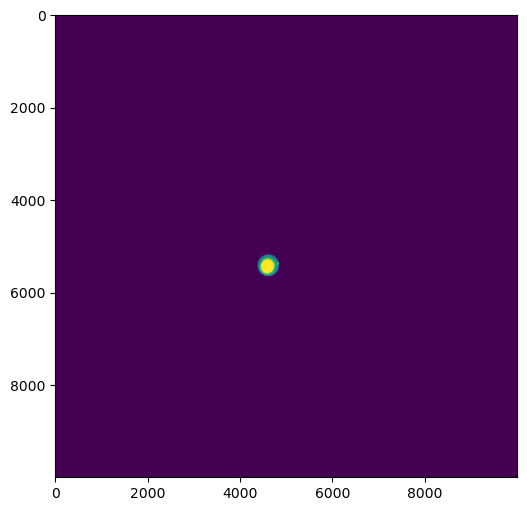

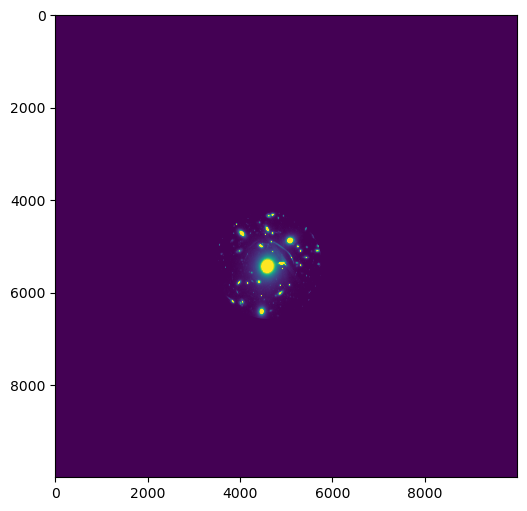

In [26]:
mask = circular_mask(drz, center, rads[0])
display_img(image=drz, mask=mask)

mask = circular_mask(drz, center, rads[9])
display_img(image=drz, mask=mask)